<small>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones, FaMAF UNC, 2021.</small>
# Exploración y Curación de Datos 

Este trabajo pertenece a la mentoría **GAP: Gestión Automática de Pedidos de Combustibles Líquidos basada en telemetría de inventarios**.

Integrantes:
- Bernaschini, María Laura
- Bosch, Daniela

## Introducción

En el trabajo anterior se hicieron algunos análisis de los datos teniendo en cuenta el dataset completo y las agrupaciones por tanque. En este trabajo, buscamos explorar un poco más los datos haciendo curación y análisis más complejos.

El filtrado de datos erróneos se hará por tanque, mientras que el análisis y procesamiento se hará agrupando por centro operativo y producto.

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
from datetime import datetime, timedelta
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.impute import SimpleImputer
from statsmodels.tsa.seasonal import seasonal_decompose

seaborn.set_context('talk')
# Set float format
pd.set_option('display.float_format','{:.2f}'.format)

# Set style
seaborn.set_style("darkgrid")
seaborn.set_palette('pastel')
seaborn.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12}) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Lectura del dataset

Teniendo en cuenta el análisis que se hizo previamente procedemos a levantar el dataset con los tipos correctos y sólamente las columnas que vamos a utilizar.

In [ ]:
dtypes = {
    "id_equipo": "category",
    "id_tanque": "category",
    "nombre_producto": "category",
    "industria": "category",
}
parse_dates = ["timestamp"]
usecols = [
    'timestamp', 'id_equipo', 'id_tanque', 'nombre_producto', 'volumen',
    'fuel_level_dmm', 'vbat2', 'capacidad', 'industria', 'codigo'
]

In [ ]:
def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_pkl_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_pickle(filename)

def read_csv_from_drive(drive, id, filename, usecols, parse_dates, dtypes):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(
        filename, 
        dtype=dtypes, 
        parse_dates=parse_dates,
        usecols=usecols
    )

drive = connect_to_drive()

In [ ]:
filename = '14KRbp2KPwMK-k_6pjD5FmbpVZ0AudBZR'
raw_df = read_csv_from_drive(
    drive, 
    filename, 
    'StorageInventory_2021_Q1.csv',
    usecols,
    parse_dates,
    dtypes
)
raw_df['volumen'] = raw_df['volumen'].astype(numpy.float32)
raw_df['capacidad'] = raw_df['capacidad'].astype(numpy.float32)
raw_df.head()

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp
0,430,964,17143.94,N1,357,9217.00,Transportation,50191.00,Product 1,2021-01-01 00:00:46
1,477,1014,16200.70,N1,304,15727.00,Service Station,21259.00,Formula Diesel,2021-01-01 00:00:24
2,477,1013,11265.10,N1,297,11579.00,Service Station,15032.00,VP Diesel,2021-01-01 00:00:31
3,477,1010,865.65,N1,302,1865.00,Service Station,15032.00,VP Nafta,2021-01-01 00:00:38
4,477,1011,1929.49,N1,272,3255.00,Service Station,15032.00,Super,2021-01-01 00:00:41


In [ ]:
# Mantenemos el original sin modificaciones
df = raw_df.copy()

## Preprocesamiento y análisis de los datos

### Agrupación por tanques

Como se vio en el trabajo anterior, fue necesario agrupar los historiales por sensor (por tanque) para realizar algunos filtrados y algunos análisis.

Para filtrados referidos a errores en los sensores, se utilizará esta agrupación, para el resto de los análisis, se agruparán por centro operativo y producto.

In [ ]:
# Ejemplo del uso de groupby
df.groupby('id_tanque').first()

,id_equipo,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp
id_tanque,,,,,,,,,
1010,477,865.65,N1,302,1865.00,Service Station,15032.00,VP Nafta,2021-01-01 00:00:38
101080,533,3905.90,N1,299,8445.00,Agriculture,10000.00,Product 1,2021-01-01 00:00:27
101098,459,26738.00,N1,359,13052.00,Agriculture,50000.00,Gasoil,2021-01-01 00:01:10
101099,534,8005.27,N1,286,8874.00,Transportation,23301.00,Product 1,2021-01-01 00:00:00
1011,477,1929.49,N1,272,3255.00,Service Station,15032.00,Super,2021-01-01 00:00:41
...,...,...,...,...,...,...,...,...,...
103272,776,1733.00,F2,319,1733.00,Telcos,900.00,Producto 1,2021-03-25 10:30:29
103273,866,7800.00,P1,321,7800.00,Transportation,40000.00,Euro,2021-03-26 12:34:47
103202,2,921.00,P1,350,921.00,Distributor,345.00,Product 2,2021-03-23 08:47:51


In [ ]:
# Centro operativo + producto para facilitar las agrupaciones posteriores
df["equipo-producto"] = df["id_equipo"].astype(str) + "-" + df["nombre_producto"].astype(str)
df["equipo-producto"] = df["equipo-producto"].astype("category")
df.head()

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto
0,430,964,17143.94,N1,357,9217.00,Transportation,50191.00,Product 1,2021-01-01 00:00:46,430-Product 1
1,477,1014,16200.70,N1,304,15727.00,Service Station,21259.00,Formula Diesel,2021-01-01 00:00:24,477-Formula Diesel
2,477,1013,11265.10,N1,297,11579.00,Service Station,15032.00,VP Diesel,2021-01-01 00:00:31,477-VP Diesel
3,477,1010,865.65,N1,302,1865.00,Service Station,15032.00,VP Nafta,2021-01-01 00:00:38,477-VP Nafta
4,477,1011,1929.49,N1,272,3255.00,Service Station,15032.00,Super,2021-01-01 00:00:41,477-Super


En la gestión automática de pedidos es preferible no detectar la falta de combustible aunque el centro operativo esté en falta (error de tipo I) que predecir erróneamente la falta del mismo (error de tipo II), ya que la misma implicaría toda una logística con elevados costos. 

Se filtrarán registros o grupo de registros completos de productos y centros operativos según los criterios:
- Eliminación únicamente de registros erróneos si estos no superan los 50 casos.
- Eliminación de grupos producto-equipo completos si alguno de los tanques del grupo no reportó en un periodo mayor a 24hs **en las últimas dos semanas**. 
- Eliminación de grupos producto-equipo completos si alguno de los tanques del grupo presentan más de 50 casos de error. Si bien podría utilizarse el mismo criterio de únicamente ver las últimas dos semanas, consideramos que se trata de una **falla registrada por el equipo o la sonda**, por lo tanto, decidimos quitarlos si aparecen en algún momento de la serie de tiempo.

**No se realizarán predicciones** sobre tales grupos debido a que contienen datos erróneos o faltantes en uno o varios tanques.

In [ ]:
# Acumulamos los centros productos que eliminamos en este dataset
removed = pd.DataFrame({}, columns=["equipo-producto"])

### Equipos y productos dónde existen volúmenes de tanque menores a 0

In [ ]:
df[df.volumen < 0]

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto
1749368,685,101613,-21.76,I0,355,0.00,Telcos,900.00,Diesel,2021-01-22 14:54:28,685-Diesel


En este caso hay un sólo dato erróneo en el equipo `685`, por lo que sólo quitaremos el caso.

### Equipos con capacidad nan, negativo o cero

In [ ]:
cap_cero = df[df.capacidad <= 0]
cap_cero

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto


In [ ]:
cap_nan = df[df.capacidad.isna()]
cap_nan["equipo-producto"] = cap_nan["equipo-producto"].cat.remove_unused_categories()
cap_nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto
855,908,102703,2171.00,F2,351,2171.00,Transportation,nan,NaN,2021-01-01 00:00:18,908-nan
2719,908,102703,2173.00,F2,351,2173.00,Transportation,nan,NaN,2021-01-01 01:00:09,908-nan
4098,908,102703,2173.00,F2,351,2173.00,Transportation,nan,NaN,2021-01-01 02:00:01,908-nan
5732,908,102703,2170.00,F2,351,2170.00,Transportation,nan,NaN,2021-01-01 03:00:51,908-nan
7297,908,102703,2173.00,F2,350,2173.00,Transportation,nan,NaN,2021-01-01 04:00:42,908-nan
...,...,...,...,...,...,...,...,...,...,...,...
10143681,983,103264,18246.00,F1,348,18246.00,Agriculture,nan,Glifosato,2021-03-22 13:46:46,983-Glifosato
10143682,983,103264,18246.00,F1,349,18246.00,Agriculture,nan,Glifosato,2021-03-22 13:47:45,983-Glifosato
10143683,983,103264,18246.00,P1,349,18246.00,Agriculture,nan,Glifosato,2021-03-22 15:20:01,983-Glifosato
10143684,983,103264,18246.00,P1,348,18246.00,Agriculture,nan,Glifosato,2021-03-22 15:24:55,983-Glifosato


In [ ]:
r = pd.DataFrame()
r["equipo-producto"] = cap_nan["equipo-producto"].unique()
r["capacidad_nan"] = True

removed = pd.merge(removed, r, on="equipo-producto", how='outer')

### Equipos y productos dónde existen volúmenes que exceden la capacidad del tanque

In [ ]:
# TODO: ver por tanque, debería ser algo tipo df.groupby("id_tanque")["volumen"].max()
df[df["volumen"] > df["capacidad"].max()]

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto
2805524,848,102358,2387534.75,L1,301,99999999.00,Service Station,5000.00,Diesel,2021-02-03 11:03:35,848-Diesel
4916353,848,102348,2912729.25,F1,999,99999999.00,Service Station,5000.00,Diesel,2021-02-19 21:15:11,848-Diesel
5659884,848,102358,810323.12,L9,999,13695225.00,Service Station,5000.00,Diesel,2021-02-25 18:32:58,848-Diesel
5976463,848,102345,2495237.00,L9,999,15380139.00,Service Station,5000.00,Diesel,2021-02-27 23:02:55,848-Diesel
6297564,848,102356,2521815.75,F9,999,99999999.00,Service Station,5000.00,Diesel,2021-03-02 05:19:10,848-Diesel
7380719,859,102331,104849.99,L1,350,5525.00,Agriculture,10000.00,Producto 0,2021-03-10 21:48:00,859-Producto 0
7380726,859,102331,105063.62,L1,350,5538.00,Agriculture,10000.00,Producto 0,2021-03-10 21:48:33,859-Producto 0
7380727,859,102331,102828.73,L1,350,5402.00,Agriculture,10000.00,Producto 0,2021-03-10 21:48:36,859-Producto 0
7380739,859,102331,104899.29,L1,350,5528.00,Agriculture,10000.00,Producto 0,2021-03-10 21:49:29,859-Producto 0
7380749,859,102331,103617.52,L1,350,5450.00,Agriculture,10000.00,Producto 0,2021-03-10 21:50:33,859-Producto 0


Los equipos que se obtuvieron fueron el `848` y el `859`. Al igual que en el caso anterior, debido a que la catidad de datos erróneos es escaso por equipo, sólo sacaremos los casos.

### Equipos y productos dónde la batería de los sensores es 0

In [ ]:
df_bat = df[df["vbat2"] == 0]
df_bat["equipo-producto"] = df_bat["equipo-producto"].cat.remove_unused_categories()
df_bat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto
272,106,75,0.00,N0,0,nan,Transportation,4096.00,Product 2,2021-01-01 00:00:00,106-Product 2
728,106,75,0.00,N0,0,nan,Transportation,4096.00,Product 2,2021-01-01 00:10:00,106-Product 2
730,106,75,0.00,N0,0,nan,Transportation,4096.00,Product 2,2021-01-01 00:20:00,106-Product 2
736,106,75,0.00,N0,0,nan,Transportation,4096.00,Product 2,2021-01-01 00:30:00,106-Product 2
737,106,75,0.00,N0,0,nan,Transportation,4096.00,Product 2,2021-01-01 00:40:00,106-Product 2
...,...,...,...,...,...,...,...,...,...,...,...
7794175,111,81,21835.60,V0,0,nan,Transportation,40000.00,Producto 0,2021-03-15 15:38:00,111-Producto 0
7794176,111,81,21798.06,V0,0,nan,Transportation,40000.00,Producto 0,2021-03-15 15:40:00,111-Producto 0
7794177,111,81,21741.77,V0,0,nan,Transportation,40000.00,Producto 0,2021-03-15 15:46:00,111-Producto 0
7794178,111,81,21798.06,N0,0,nan,Transportation,40000.00,Producto 0,2021-03-15 16:00:00,111-Producto 0


Observamos algunos casos.

In [ ]:
bat = pd.DataFrame(df_bat["equipo-producto"].value_counts())
bat

,equipo-producto
111-BIO,2930
111-Producto 0,2262
106-Product 2,1930
69-nan,1117
848-Diesel,96
353-GASOIL,9
946-Producto 1,1


Quiraremos los grupos: 
- `111` productos "BIO" y "Producto 0", 
- `106` "Producto 2", 
- `69` y 
- `848` producto "Diesel". 

En el caso de los equipos `353` y `946` sólo eliminaremos los casos ya que son pocos.

In [ ]:
r = pd.DataFrame()
r["equipo-producto"] = bat.index[:5].unique()
r["pilas_cero"] = True

removed = pd.merge(removed, r, on="equipo-producto", how='outer')

### Equipos y productos donde el volumen de combustible es 0 y el nivel mayor a 0

In [ ]:
df_fuel = df[(df.volumen == 0) & (df.fuel_level_dmm > 0)]
df_fuel["equipo-producto"] = df_fuel["equipo-producto"].cat.remove_unused_categories()
df_fuel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto
1606,685,101615,0.00,F2,355,486.00,Telcos,1000.00,Diesel,2021-01-01 00:00:14,685-Diesel
1608,685,101614,0.00,F1,272,332.00,Telcos,1000.00,Diesel,2021-01-01 00:01:40,685-Diesel
1903,685,101615,0.00,F2,355,487.00,Telcos,1000.00,Diesel,2021-01-01 00:30:39,685-Diesel
1905,685,101614,0.00,F1,272,332.00,Telcos,1000.00,Diesel,2021-01-01 00:31:06,685-Diesel
3245,685,101615,0.00,F2,355,487.00,Telcos,1000.00,Diesel,2021-01-01 01:00:05,685-Diesel
...,...,...,...,...,...,...,...,...,...,...,...
10137422,685,101615,0.00,F2,352,490.00,Telcos,1000.00,Diesel,2021-03-31 22:46:23,685-Diesel
10138974,685,101615,0.00,F2,352,491.00,Telcos,1000.00,Diesel,2021-03-31 23:01:07,685-Diesel
10139653,685,101615,0.00,F2,351,491.00,Telcos,1000.00,Diesel,2021-03-31 23:16:48,685-Diesel
10140191,685,101615,0.00,F2,351,491.00,Telcos,1000.00,Diesel,2021-03-31 23:31:31,685-Diesel


Observamos algunos casos.

In [ ]:
fuel = pd.DataFrame(df_fuel["equipo-producto"].value_counts())
fuel

,equipo-producto
685-Diesel,6573
534-Product 1,1234
843-Diesel,171
356-Kerosene,106
763-nan,60
848-Diesel,3
905-Producto 1,1
577-Product 1,1


En esta oportunidad, quitaremos los equipos `685`, `534`, `843`, `356` y `763`, y en el caso de los equipos `848`, `577` y `905` eliminaremos los casos ya que son pocos.

In [ ]:
r = pd.DataFrame()
r["equipo-producto"] = fuel.index[:5].unique()
r["volumen_cero_fuel_nocero"] = True

removed = pd.merge(removed, r, on="equipo-producto", how='outer')

### Equipos y productos donde el eco de las sondas es 0

In [ ]:
# Separamos el código en dos datos
df['c'] = df['codigo'].apply(lambda x: str(x)[0])
df['echoes'] = pd.to_numeric(df['codigo'].apply(lambda x: str(x)[1]), errors='coerce')

In [ ]:
df_echoes = df[df["echoes"] == 0]
df_echoes["equipo-producto"] = df_echoes["equipo-producto"].cat.remove_unused_categories()
df_echoes[:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto,c,echoes
180,400,976,170.40,N0,307,418.00,Transportation,40000.00,Formula Diesel,2021-01-01 00:01:23,400-Formula Diesel,N,0.00
230,175,257,27647.12,N0,199,nan,Construction,50000.00,Product 1,2021-01-01 00:00:00,175-Product 1,N,0.00
272,106,75,0.00,N0,0,nan,Transportation,4096.00,Product 2,2021-01-01 00:00:00,106-Product 2,N,0.00
291,520,102046,0.00,F0,353,0.00,Transportation,1000.00,UREA,2021-01-01 00:00:26,520-UREA,F,0.00
346,761,101794,0.00,m0,353,0.00,Transportation,50000.00,Product 1,2021-01-01 00:01:42,761-Product 1,m,0.00
365,669,102150,162.97,N0,350,580.00,Transportation,20000.00,Producto 0,2021-01-01 00:00:46,669-Producto 0,N,0.00
613,520,102046,0.00,F0,353,0.00,Transportation,1000.00,UREA,2021-01-01 00:30:52,520-UREA,F,0.00
625,400,976,170.40,N0,307,418.00,Transportation,40000.00,Formula Diesel,2021-01-01 00:31:53,400-Formula Diesel,N,0.00
628,400,976,170.40,N0,306,418.00,Transportation,40000.00,Formula Diesel,2021-01-01 01:01:24,400-Formula Diesel,N,0.00
721,175,257,27644.85,N0,200,nan,Construction,50000.00,Product 1,2021-01-01 00:30:00,175-Product 1,N,0.00


In [ ]:
pd.DataFrame(df_echoes["equipo-producto"].value_counts())[:20]

,equipo-producto
646-Gas Oil,14880
848-Diesel,12287
175-Product 1,10798
520-UREA,4967
180-Infinia Diésel,4306
731-Diesel,3588
819-nan,3314
639-Euro 3,3304
111-BIO,2903
802-B100,2497


Graficamos algunos ejemplos.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


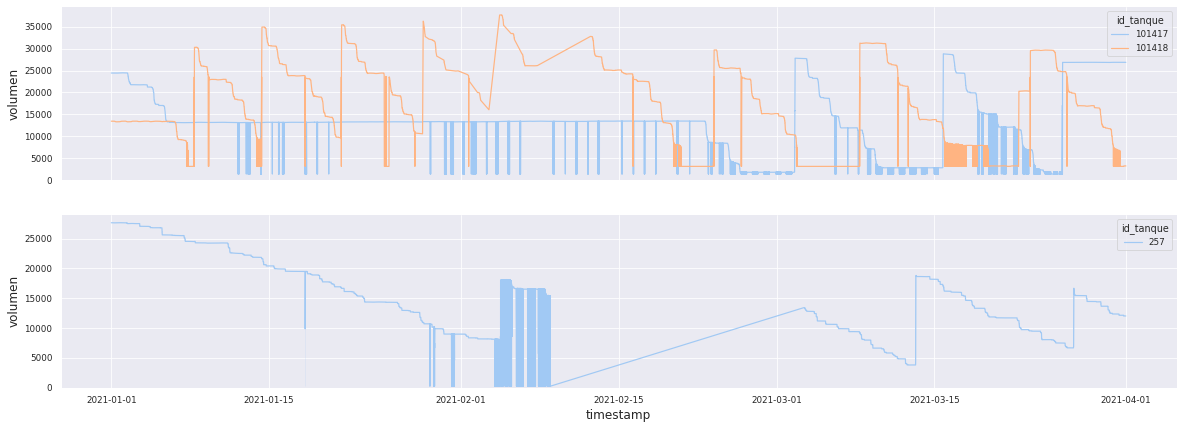

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(20, 7))
ej1 = df.query("`equipo-producto` == '646-Gas Oil'")
ej2 = df.query("`equipo-producto` == '175-Product 1'")
ej1.loc[:,'id_tanque'] = ej1['id_tanque'].cat.remove_unused_categories()
ej2.loc[:,'id_tanque'] = ej2['id_tanque'].cat.remove_unused_categories()

seaborn.lineplot(
    data=ej1, 
    y='volumen', 
    x='timestamp', 
    hue='id_tanque',
    ax=axes[0]
).axes.set(ylim=(0, None))
seaborn.lineplot(
    data=ej2, 
    y='volumen', 
    x='timestamp', 
    hue='id_tanque',
    ax=axes[1]
).axes.set(ylim=(0, None))
seaborn.despine()

Para este caso, definimos un criterio de eliminación ya que son muchos los equipos con ecos 0. Como se muestra más adelante, se quitaron aquellos equipos que presentaban más de 50 ecos 0.  

In [ ]:
ecos = pd.DataFrame(df[df["echoes"] == 0]["equipo-producto"])
ecos.loc[:,"equipo-producto"] = ecos["equipo-producto"].cat.remove_unused_categories()
ecos = ecos.groupby("equipo-producto").first()[ecos["equipo-producto"].value_counts() > 50]
ecos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


""
equipo-producto
106-Product 2
111-BIO
111-Producto 0
175-Product 1
179-Infinia Diésel
180-Infinia Diésel
326-Gasoil
353-GASOIL
400-Formula Diesel


In [ ]:
r = pd.DataFrame()
r["equipo-producto"] = ecos.index
r["ecos_cero"] = True

removed = pd.merge(removed, r, on="equipo-producto", how='outer')

### Equipos y productos donde el eco de las sondas es mayor a 2

In [ ]:
df[df["echoes"] > 2]

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto,c,echoes
1627316,451,101661,13354.45,L3,316,7887.00,Agriculture,50000.10,Diesel,2021-01-21 12:09:09,451-Diesel,L,3.00
1627323,451,101661,26163.81,L4,315,13008.00,Agriculture,50000.10,Diesel,2021-01-21 12:09:42,451-Diesel,L,4.00
1627366,451,101661,3597.30,L3,315,3145.00,Agriculture,50000.10,Diesel,2021-01-21 12:11:25,451-Diesel,L,3.00
1627370,451,101661,14.25,V6,315,30.00,Agriculture,50000.10,Diesel,2021-01-21 12:11:28,451-Diesel,V,6.00
1815363,451,101661,50477.50,L3,313,24154.00,Agriculture,50000.10,Diesel,2021-01-23 13:28:59,451-Diesel,L,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8479156,466,101246,42647.21,L3,303,31719.00,Agriculture,40000.00,S1002050010,2021-03-20 09:57:15,466-S1002050010,L,3.00
8479481,466,101246,42674.76,L4,302,32051.00,Agriculture,40000.00,S1002050010,2021-03-20 10:04:21,466-S1002050010,L,4.00
8479554,466,101246,42674.43,L3,302,32047.00,Agriculture,40000.00,S1002050010,2021-03-20 10:07:20,466-S1002050010,L,3.00
8479563,466,101246,42626.29,L3,303,31467.00,Agriculture,40000.00,S1002050010,2021-03-20 10:07:35,466-S1002050010,L,3.00


### Equipos con códigos de error

In [ ]:
error_codes = ['m', 'M', 'F']
df.query("c in @error_codes")

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto,c,echoes
177,353,679,21371.00,F1,320,nan,Construction,40000.00,GASOIL,2021-01-01 00:30:00,353-GASOIL,F,1.00
291,520,102046,0.00,F0,353,0.00,Transportation,1000.00,UREA,2021-01-01 00:00:26,520-UREA,F,0.00
346,761,101794,0.00,m0,353,0.00,Transportation,50000.00,Product 1,2021-01-01 00:01:42,761-Product 1,m,0.00
379,797,101978,7322.00,F1,353,7322.00,Agriculture,15000.00,Product 2,2021-01-01 00:00:03,797-Product 2,F,1.00
518,216,493,10538.00,M1,363,nan,Transportation,51000.00,Product 1,2021-01-01 00:00:00,216-Product 1,M,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10145580,64,103306,18246.00,F1,348,18246.00,Distributor,50000.10,Producto 0,2021-03-31 15:47:32,64-Producto 0,F,1.00
10145581,64,103306,18246.00,F1,348,18246.00,Distributor,50000.10,Producto 0,2021-03-31 15:48:31,64-Producto 0,F,1.00
10145582,64,103306,18246.00,F1,348,18246.00,Distributor,50000.10,Producto 0,2021-03-31 15:49:30,64-Producto 0,F,1.00
10145583,64,103306,18246.00,F1,348,18246.00,Distributor,50000.10,Producto 0,2021-03-31 15:50:29,64-Producto 0,F,1.00


Para este caso, definimos un criterio de eliminación ya que son muchos los equipos con códigos de error. Como se muestra más adelante, se quitaron aquellos equipos que presentaban más de 50 registros con códigos de error.  

In [ ]:
# Equipos con un conteo de valores de código de error mayor a 50
error = pd.DataFrame(df[df["c"].isin(error_codes)]["equipo-producto"])
error.loc[:,"equipo-producto"] = error["equipo-producto"].cat.remove_unused_categories()
error = error.groupby("equipo-producto").first()[error["equipo-producto"].value_counts() > 50]
error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


""
equipo-producto
122-Product 2
123-Product 2
2-Product 1
2-Product 2
216-Product 1
...
932-Producto 2
932-Producto 3
944-Producto 0


In [ ]:
r = pd.DataFrame()
r["equipo-producto"] = error.index
r["codigo_error"] = True

removed = pd.merge(removed, r, on="equipo-producto", how='outer')

## Filtrado de casos y equipos

Filtramos todos los casos y los grupos mencionados anteriormente.

In [ ]:
len(df)

10148505

In [ ]:
# Casos
df = df[~(df.volumen < 0)]
df = df[~(df.volumen > df.capacidad.max())]
df = df[~(df.echoes > 2)]
df = df[~(df.echoes == 0)]
df = df[~(df["c"].isin(error_codes))]

# Grupos centro producto
df = df[~(df["equipo-producto"].isin(removed["equipo-producto"]))]

In [ ]:
len(df)

4751137

Probamos si el filtrado por equipo en relación a los ecos se realizó correctamente

In [ ]:
df[df.id_equipo=="646"]

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto,c,echoes


In [ ]:
df[df.id_equipo=="619"]

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto,c,echoes


## Filtrado de centros por los gaps
Debido a la eliminación de datos erróneos, se generaron espacios de tiempo sin datos en algunos tanques. Otro motivo por el cual puedan existir estos gaps, es debido a que la sonda o la consola no reportan a la nube, por problemas de conectividad, entre otros.


Se filtrarán centros operativos en donde al menos uno de los tanques del grupo tiene un espacio de tiempo sin datos de al menos 24hs.

In [ ]:
df['delta_timestamp'] = df.groupby('id_tanque')['timestamp'].diff()

In [ ]:
df.timestamp.max()

Timestamp('2021-03-31 23:59:58')

In [ ]:
cond3 = (df['delta_timestamp'] > '1 days')
cond4 = (df['timestamp'] > datetime(2021, 3, 15, 23, 59, 58))
cond5 = (df['timestamp'] < datetime(2021, 3, 31, 23, 59, 58))

gaps = pd.DataFrame(df[cond3 & cond4 & cond5]["equipo-producto"].unique())
gaps

,0
0,895-Producto 0
1,653-GAS OIL
2,422-Ultra Diesel
3,597-Gas Oil Euro Gr 3
4,490-Product 1
5,385-Gas Oil
6,738-Diesel Comun
7,817-Diesel 500
8,582-Producto 0
9,688-Diesel


Graficamos un ejemplo

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


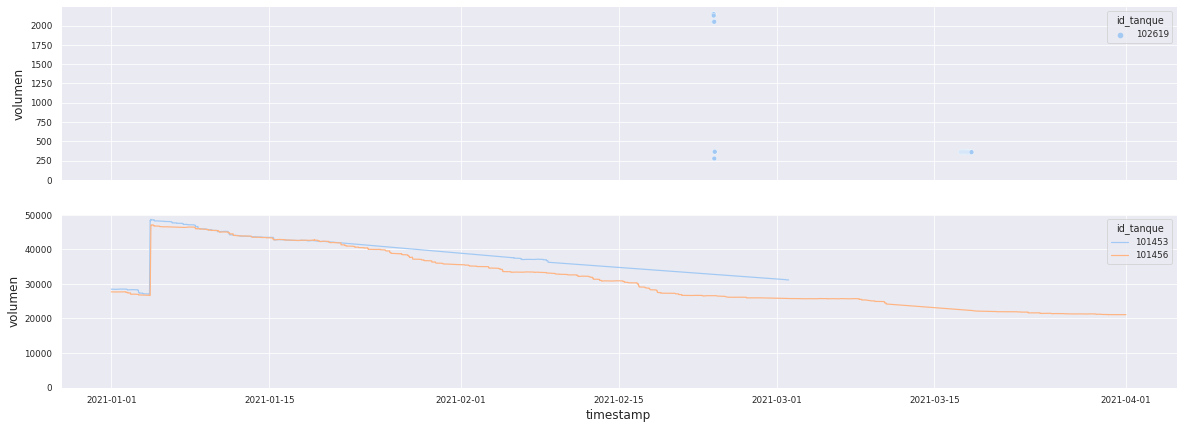

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(20, 7))
ej1 = df.query("`equipo-producto` == '895-Producto 0'")
ej2 = df.query("`equipo-producto` == '653-GAS OIL'")
ej1.loc[:,'id_tanque'] = ej1['id_tanque'].cat.remove_unused_categories()
ej2.loc[:,'id_tanque'] = ej2['id_tanque'].cat.remove_unused_categories()

seaborn.scatterplot(
    data=ej1, 
    y='volumen', 
    x='timestamp', 
    hue='id_tanque',
    ax=axes[0]
).axes.set(ylim=(0, None))
seaborn.lineplot(
    data=ej2, 
    y='volumen', 
    x='timestamp', 
    hue='id_tanque',
    ax=axes[1]
).axes.set(ylim=(0, None))
seaborn.despine()

In [ ]:
r = pd.DataFrame()
r["equipo-producto"] = gaps[0]
r["gaps"] = True

removed = pd.merge(removed, r, on="equipo-producto", how='outer')

In [ ]:
df = df[~(df["equipo-producto"].isin(removed["equipo-producto"]))]

Finalmente, los centros operativos - productos eliminados fueron:

In [ ]:
removed = removed.fillna(False)
removed

,equipo-producto,capacidad_nan,pilas_cero,volumen_cero_fuel_nocero,ecos_cero,codigo_error,gaps
0,908-nan,True,False,False,False,True,False
1,843-Diesel,True,False,True,True,False,False
2,911-nan,True,False,False,False,True,False
3,908-Producto 0,True,False,False,False,False,False
4,669-Producto 0,True,False,False,True,False,False
...,...,...,...,...,...,...,...
126,866-Euro,False,False,False,False,False,True
127,631-Product 1,False,False,False,False,False,True
128,800-Super,False,False,False,False,False,True
129,671-DIESEL,False,False,False,False,False,True


## Uniformidad de la serie temporal

Para poder hacer las agregaciones necesarias, necesitamos realizar un resampleo de los datos por una unidad de tiempo uniforme, de lo contrario, los datos no pueden ser comparables y agregables entre tanques.

Vemos además que antes de realizar el sampleo, será necesario filtrar los registros duplicados. Esto se debe al reporte de dos mediciones en el mismo timestamp con dos códigos distintos. Para esta etapa no los necesitamos y los erróneos fueron eliminados previamente, por lo tanto, podemos quitar uno de ellos.

In [ ]:
# Ejemplo de un tanque que reportó duplicado
df.query("id_tanque == '1010'").tail()

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,timestamp,equipo-producto,c,echoes,delta_timestamp
10136161,477,1010,7558.80,N1,298,8554.00,Service Station,15032.00,VP Nafta,2021-03-31 23:53:07,477-VP Nafta,N,1.00,0 days 00:00:59
10136162,477,1010,7558.80,V1,298,8554.00,Service Station,15032.00,VP Nafta,2021-03-31 23:53:07,477-VP Nafta,V,1.00,0 days 00:00:00
10136166,477,1010,7558.80,N1,297,8554.00,Service Station,15032.00,VP Nafta,2021-03-31 23:54:06,477-VP Nafta,N,1.00,0 days 00:00:59
10136171,477,1010,7558.80,N1,298,8554.00,Service Station,15032.00,VP Nafta,2021-03-31 23:56:03,477-VP Nafta,N,1.00,0 days 00:01:57
10136180,477,1010,7557.60,N1,298,8553.00,Service Station,15032.00,VP Nafta,2021-03-31 23:59:00,477-VP Nafta,N,1.00,0 days 00:02:57


In [ ]:
resampled_df = df.groupby('id_tanque', as_index=False)\
    .apply(
        lambda x : x.drop_duplicates('timestamp')\
                .set_index('timestamp')\
                .resample('5min')\
                .bfill())\
    .reset_index()\
    .set_index('timestamp')\
    .drop(columns=['level_0'])
resampled_df.head()

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,equipo-producto,c,echoes,delta_timestamp
timestamp,,,,,,,,,,,,,
2021-01-01 00:00:00,477,1010,865.65,N1,302,1865.00,Service Station,15032.00,VP Nafta,477-VP Nafta,N,1.00,NaT
2021-01-01 00:05:00,477,1010,865.65,N1,302,1865.00,Service Station,15032.00,VP Nafta,477-VP Nafta,N,1.00,0 days 00:00:59
2021-01-01 00:10:00,477,1010,865.65,N1,302,1865.00,Service Station,15032.00,VP Nafta,477-VP Nafta,N,1.00,0 days 00:00:59
2021-01-01 00:15:00,477,1010,865.65,N1,302,1865.00,Service Station,15032.00,VP Nafta,477-VP Nafta,N,1.00,0 days 00:01:58
2021-01-01 00:20:00,477,1010,864.98,N1,302,1864.00,Service Station,15032.00,VP Nafta,477-VP Nafta,N,1.00,0 days 00:03:56


Graficamos un ejemplo

In [ ]:
co_900 = resampled_df[resampled_df.id_equipo == "900"]
# Debemos remover las categorías no utilizadas
co_900.loc[:,'id_tanque'] = co_900['id_tanque']\
    .cat.remove_unused_categories()
co_900.loc[:,'nombre_producto'] = co_900['nombre_producto']\
    .cat.remove_unused_categories()

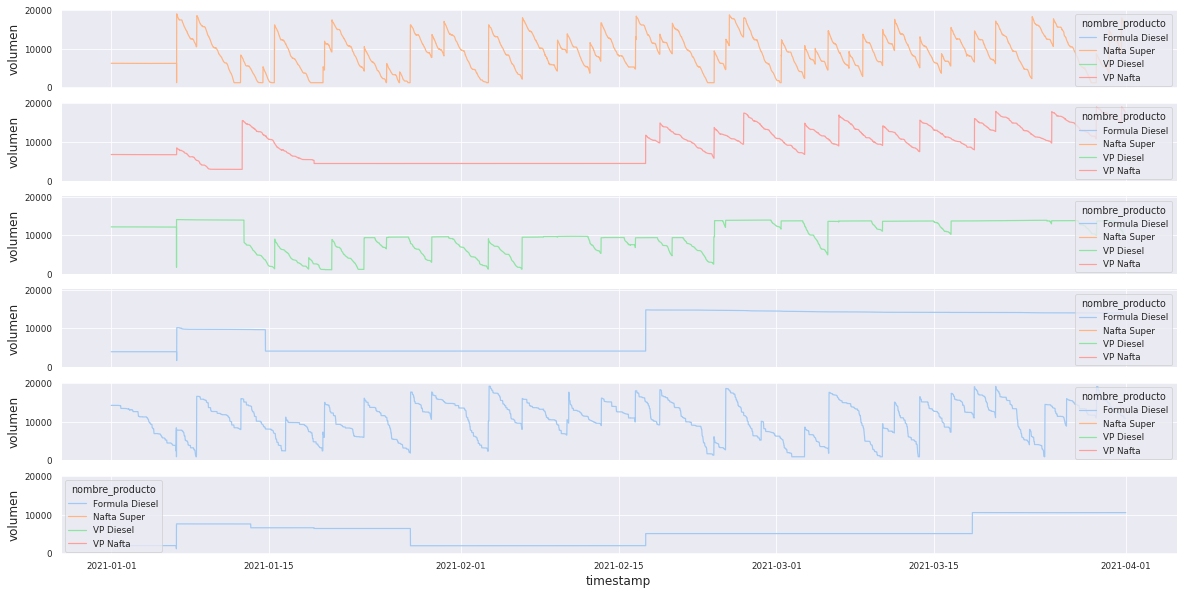

In [ ]:
n = co_900['id_tanque'].nunique()
fig, axes = plt.subplots(n, 1, sharex=True, sharey=True, figsize=(20, 10))

for i, tanque in enumerate(co_900['id_tanque'].unique()):
    seaborn.lineplot(
        data=co_900.query("id_tanque == @tanque"), 
        y='volumen', 
        x='timestamp',
        hue='nombre_producto', 
        ax=axes[i]
    )
seaborn.despine()

## Consumos por producto y centros operativos

Para poder calcular los consumos, debemos sumar todas las diferencias negativas (primera derivada) por centro operativo y producto. 

A veces puede haber ruido en el volumen histórico de los tanques que pueden confundirse con movimientos de combustible, por lo tanto, no sería correcto utilizar las diferencias entre volúmenes en el tiempo sin ningún tratamiento previo. Necesitamos suavizar los registros para obtener las diferencias reales. Para obtener el cálculo de consumos más preciso se utilizan las **direfencias entre las medias móviles**. 

In [ ]:
resampled_df['moving_avg'] = resampled_df.groupby('id_tanque')['volumen'].transform(
    lambda x: x.rolling(window=4).mean()
)

In [ ]:
resampled_df['volumen_diff'] = resampled_df.groupby('id_tanque')['moving_avg'].diff()

In [ ]:
resampled_df['consumo'] = numpy.where(
    resampled_df['volumen_diff'] < 0, 
    resampled_df['volumen_diff'].abs(), 
    0
)

In [ ]:
resampled_df.tail()

,id_equipo,id_tanque,volumen,codigo,vbat2,fuel_level_dmm,industria,capacidad,nombre_producto,equipo-producto,c,echoes,delta_timestamp,moving_avg,volumen_diff,consumo
timestamp,,,,,,,,,,,,,,,,
2021-03-31 23:10:00,704,101645,0.00,N1,315,0.00,Public,50000.00,Infinia Diésel,704-Infinia Diésel,N,1.00,0 days 00:29:26,0.00,0.00,0.00
2021-03-31 23:15:00,704,101645,0.00,N1,315,0.00,Public,50000.00,Infinia Diésel,704-Infinia Diésel,N,1.00,0 days 00:29:26,0.00,0.00,0.00
2021-03-31 23:20:00,704,101645,0.00,N1,315,0.00,Public,50000.00,Infinia Diésel,704-Infinia Diésel,N,1.00,0 days 00:29:26,0.00,0.00,0.00
2021-03-31 23:25:00,704,101645,0.00,N1,315,0.00,Public,50000.00,Infinia Diésel,704-Infinia Diésel,N,1.00,0 days 00:29:26,0.00,0.00,0.00
2021-03-31 23:30:00,704,101645,0.00,N1,315,0.00,Public,50000.00,Infinia Diésel,704-Infinia Diésel,N,1.00,0 days 00:29:26,0.00,0.00,0.00


### Agrupación por centro operativo y producto

El objetivo del proyecto es predecir cuándo un centro operativo va a quedarse sin combustible, por lo tanto la predicción por tanque no sería correcta ya que no se justificaría generar toda una logística de pedido del producto por un solo tanque.

Una vez filtrados los datos, necesitamos sumar las capacidades y los volúmenes de los tanques por centro operativo y por producto.



In [ ]:
grouped_prod_equipo = resampled_df\
    .groupby(['id_equipo', 'nombre_producto', 'timestamp'], observed=True)\
    .agg({
        'capacidad':'sum', 
        'volumen':'sum', 
        "consumo": "sum",
        'industria': 'first',
    })\
    .reset_index()\
    .set_index('timestamp')
grouped_prod_equipo.head()

,id_equipo,nombre_producto,capacidad,volumen,consumo,industria
timestamp,,,,,,
2021-01-01 00:00:00,477,VP Nafta,15032.00,865.65,0.00,Service Station
2021-01-01 00:05:00,477,VP Nafta,15032.00,865.65,0.00,Service Station
2021-01-01 00:10:00,477,VP Nafta,15032.00,865.65,0.00,Service Station
2021-01-01 00:15:00,477,VP Nafta,15032.00,865.65,0.00,Service Station
2021-01-01 00:20:00,477,VP Nafta,15032.00,864.98,0.17,Service Station



Graficamos el mismo centro operativo de ejemplo.

In [ ]:
co_900_grouped = grouped_prod_equipo.query("id_equipo == '900'")
# Debemos remover las categorías no utilizadas
co_900_grouped.loc[:,'nombre_producto'] = co_900_grouped['nombre_producto']\
    .cat.remove_unused_categories()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


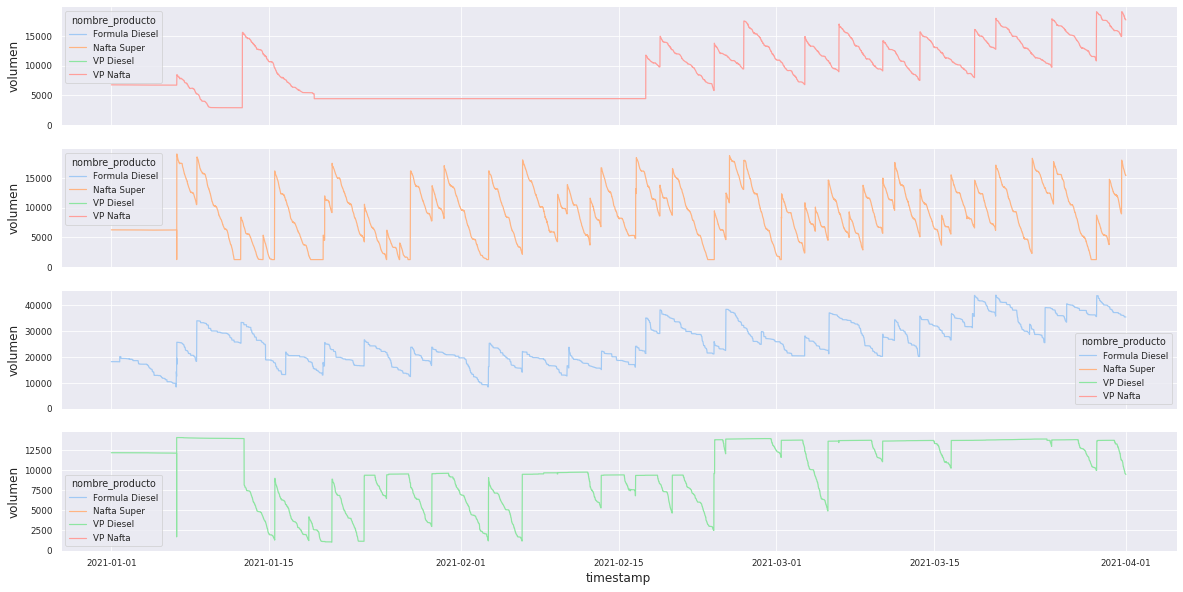

In [ ]:
n = co_900_grouped['nombre_producto'].nunique()
fig, axes = plt.subplots(n, 1, sharex=True, sharey=False, figsize=(20, 10))

for i, producto in enumerate(co_900_grouped['nombre_producto'].unique()):
    seaborn.lineplot(
        data=co_900_grouped.query("nombre_producto == @producto"), 
        y='volumen', 
        x='timestamp', 
        hue='nombre_producto', 
        ax=axes[i]
    ).axes.set(ylim=(0, None))
seaborn.despine()

## Imputación de datos faltantes

In [ ]:
grouped_prod_equipo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3936340 entries, 2021-01-01 00:00:00 to 2021-03-31 23:30:00
Data columns (total 6 columns):
 #   Column           Dtype   
---  ------           -----   
 0   id_equipo        category
 1   nombre_producto  category
 2   capacidad        float32 
 3   volumen          float32 
 4   consumo          float32 
 5   industria        object  
dtypes: category(2), float32(3), object(1)
memory usage: 116.4+ MB


In [ ]:
grouped_prod_equipo.isna().sum()

id_equipo              0
nombre_producto        0
capacidad              0
volumen                0
consumo                0
industria          76930
dtype: int64

In [ ]:
group_ind_na=grouped_prod_equipo[grouped_prod_equipo.industria.isna()]
group_ind_na[:6]

,id_equipo,nombre_producto,capacidad,volumen,consumo,industria
timestamp,,,,,,
2021-01-01 00:00:00,553,Product 1,5000.00,4609.70,0.00,NaN
2021-01-01 00:05:00,553,Product 1,5000.00,4609.70,0.00,NaN
2021-01-01 00:10:00,553,Product 1,5000.00,4609.70,0.00,NaN
2021-01-01 00:15:00,553,Product 1,5000.00,4609.70,0.00,NaN
2021-01-01 00:20:00,553,Product 1,5000.00,4609.70,0.00,NaN
2021-01-01 00:25:00,553,Product 1,5000.00,4609.70,0.00,NaN


In [ ]:
group_ind_na.id_equipo.unique()

['553', '554', '925', '930', '927', ..., '923', '928', '924', '926', '737']
Length: 11
Categories (11, object): ['553', '554', '925', '930', ..., '928', '924', '926', '737']

In [ ]:
grouped_prod_equipo[grouped_prod_equipo.id_equipo=="554"]

,id_equipo,nombre_producto,capacidad,volumen,consumo,industria
timestamp,,,,,,
2021-01-01 00:00:00,554,Product 1,5000.00,5062.16,0.00,NaN
2021-01-01 00:05:00,554,Product 1,5000.00,5062.16,0.00,NaN
2021-01-01 00:10:00,554,Product 1,5000.00,5062.16,0.00,NaN
2021-01-01 00:15:00,554,Product 1,5000.00,5062.16,0.00,NaN
2021-01-01 00:20:00,554,Product 1,5000.00,5062.16,0.00,NaN
...,...,...,...,...,...,...
2021-03-31 23:35:00,554,Product 1,5000.00,3460.61,0.00,NaN
2021-03-31 23:40:00,554,Product 1,5000.00,3460.61,0.00,NaN
2021-03-31 23:45:00,554,Product 1,5000.00,3460.61,0.00,NaN


Se imputarán con la constante "Unknown" los valores nulos de industria ya que, como se observó en el práctico anterior, no corresponden a una identificación de la industria, por lo cual, no hay posibilidad de imputar estos valores.

In [ ]:
# grouped_prod_equipo.dropna(subset=["industria"], axis=0, inplace=True)
imputer = SimpleImputer(missing_values=numpy.nan, strategy='constant', fill_value='Unknown')
X = imputer.fit_transform(grouped_prod_equipo)
grouped_prod_equipo = pd.DataFrame(X, columns=grouped_prod_equipo.columns, index=grouped_prod_equipo.index)
grouped_prod_equipo

,id_equipo,nombre_producto,capacidad,volumen,consumo,industria
timestamp,,,,,,
2021-01-01 00:00:00,477,VP Nafta,15032.00,865.65,0.00,Service Station
2021-01-01 00:05:00,477,VP Nafta,15032.00,865.65,0.00,Service Station
2021-01-01 00:10:00,477,VP Nafta,15032.00,865.65,0.00,Service Station
2021-01-01 00:15:00,477,VP Nafta,15032.00,865.65,0.00,Service Station
2021-01-01 00:20:00,477,VP Nafta,15032.00,864.98,0.17,Service Station
...,...,...,...,...,...,...
2021-03-31 23:10:00,704,Infinia Diésel,50000.00,0.00,0.00,Public
2021-03-31 23:15:00,704,Infinia Diésel,50000.00,0.00,0.00,Public
2021-03-31 23:20:00,704,Infinia Diésel,50000.00,0.00,0.00,Public


In [ ]:
grouped_prod_equipo.isna().sum()

id_equipo          0
nombre_producto    0
capacidad          0
volumen            0
consumo            0
industria          0
dtype: int64

In [ ]:
grouped_prod_equipo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936340 entries, 0 to 3936339
Data columns (total 6 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id_equipo        object
 1   nombre_producto  object
 2   capacidad        object
 3   volumen          object
 4   consumo          object
 5   industria        object
dtypes: object(6)
memory usage: 180.2+ MB


## Escalado del volumen y consumo por la capacidad por centro-producto

In [ ]:
grouped_prod_equipo["volumen_escl"] = grouped_prod_equipo["volumen"]/grouped_prod_equipo["capacidad"]

In [ ]:
grouped_prod_equipo["consumo_escl"] = grouped_prod_equipo["consumo"]/grouped_prod_equipo["capacidad"]

In [ ]:
grouped_prod_equipo[:6]

,id_equipo,nombre_producto,capacidad,volumen,consumo,industria,volumen_escl,consumo_escl
timestamp,,,,,,,,
2021-01-01 00:00:00,477,VP Nafta,15032.00,865.65,0.00,Service Station,0.06,0.00
2021-01-01 00:05:00,477,VP Nafta,15032.00,865.65,0.00,Service Station,0.06,0.00
2021-01-01 00:10:00,477,VP Nafta,15032.00,865.65,0.00,Service Station,0.06,0.00
2021-01-01 00:15:00,477,VP Nafta,15032.00,865.65,0.00,Service Station,0.06,0.00
2021-01-01 00:20:00,477,VP Nafta,15032.00,864.98,0.17,Service Station,0.06,0.00
2021-01-01 00:25:00,477,VP Nafta,15032.00,865.65,0.00,Service Station,0.06,0.00


## Eliminación de columnas

Una vez completa la curación, se eliminan las columnas que ya no se van a necesitar.

In [ ]:
grouped_prod_equipo.drop(columns=["volumen", "consumo"], axis=1, inplace=True)

In [ ]:
grouped_prod_equipo.head()

,id_equipo,nombre_producto,capacidad,industria,volumen_escl,consumo_escl
timestamp,,,,,,
2021-01-01 00:00:00,477,VP Nafta,15032.00,Service Station,0.06,0.00
2021-01-01 00:05:00,477,VP Nafta,15032.00,Service Station,0.06,0.00
2021-01-01 00:10:00,477,VP Nafta,15032.00,Service Station,0.06,0.00
2021-01-01 00:15:00,477,VP Nafta,15032.00,Service Station,0.06,0.00
2021-01-01 00:20:00,477,VP Nafta,15032.00,Service Station,0.06,0.00


## Guardado de los modelos

Finalmente guardamos los datos procesados en formato pickle para ser utilizado en trabajos posteriores.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/DiploDatos/Mentoría/Datasets/curated_df.pkl'
# path = '/content/drive/MyDrive/Colab Notebooks/Diplo_Datos/Mentoria_GAP/curated_df.pkl'
grouped_prod_equipo.to_pickle(path)

Mounted at /content/drive


Levantamos el archivo pickle y graficamos la última semana de alguno de los modelos.

In [ ]:
pkl_key = '11ihPPpzsS_9R5Kb--ZQNuDjFTzYkgc4C'
curated_pkl = read_pkl_from_drive(drive, pkl_key, 'curated_df.pkl')

In [ ]:
curated_pkl.head()

,id_equipo,nombre_producto,capacidad,industria,volumen_escl,consumo_escl
timestamp,,,,,,
2021-01-01 00:00:00,477,VP Nafta,15032.00,Service Station,0.06,0.00
2021-01-01 00:05:00,477,VP Nafta,15032.00,Service Station,0.06,0.00
2021-01-01 00:10:00,477,VP Nafta,15032.00,Service Station,0.06,0.00
2021-01-01 00:15:00,477,VP Nafta,15032.00,Service Station,0.06,0.00
2021-01-01 00:20:00,477,VP Nafta,15032.00,Service Station,0.06,0.00


In [ ]:
curated_pkl.id_equipo.value_counts()

900    103680
486    103675
357    103669
429    103664
799    103660
        ...  
912        15
918        15
913        14
2           2
917         1
Name: id_equipo, Length: 156, dtype: int64

In [ ]:
curated_pkl[curated_pkl.id_equipo=="248"]

,id_equipo,nombre_producto,capacidad,industria,volumen_escl,consumo_escl
timestamp,,,,,,
2021-01-01 00:00:00,248,Infinia Diesel,31500.00,Service Station,0.24,0.00
2021-01-01 00:05:00,248,Infinia Diesel,31500.00,Service Station,0.24,0.00
2021-01-01 00:10:00,248,Infinia Diesel,31500.00,Service Station,0.24,0.00
2021-01-01 00:15:00,248,Infinia Diesel,31500.00,Service Station,0.24,0.00
2021-01-01 00:20:00,248,Infinia Diesel,31500.00,Service Station,0.24,0.00
...,...,...,...,...,...,...
2021-03-31 23:35:00,248,D500,42430.00,Service Station,0.44,0.00
2021-03-31 23:40:00,248,D500,42430.00,Service Station,0.44,0.00
2021-03-31 23:45:00,248,D500,42430.00,Service Station,0.44,0.00


In [ ]:
co_248_d500 = curated_pkl[(curated_pkl["id_equipo"]=="248") & (curated_pkl["nombre_producto"]=="D500")] 
co_248_d500.head()

,id_equipo,nombre_producto,capacidad,industria,volumen_escl,consumo_escl
timestamp,,,,,,
2021-01-01 00:00:00,248,D500,42430.00,Service Station,0.88,0.00
2021-01-01 00:05:00,248,D500,42430.00,Service Station,0.88,0.00
2021-01-01 00:10:00,248,D500,42430.00,Service Station,0.88,0.00
2021-01-01 00:15:00,248,D500,42430.00,Service Station,0.88,0.00
2021-01-01 00:20:00,248,D500,42430.00,Service Station,0.88,0.00


In [ ]:
co_248_d500.dtypes

id_equipo          object
nombre_producto    object
capacidad          object
industria          object
volumen_escl       object
consumo_escl       object
dtype: object

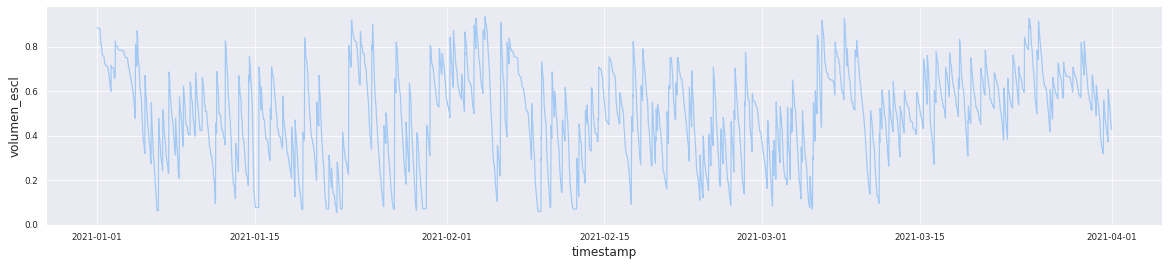

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(20, 4))

seaborn.lineplot(
    x=co_248_d500.index, 
    y=co_248_d500["volumen_escl"].astype(float), 
).axes.set(ylim=(0, None))
seaborn.despine()

## Análisis

Luego del trabajo de curación y guardado de los datos, realizamos algunos análisis  postprocesamiento para ser tenidos en cuenta en los próximos trabajos.

### Estacionalidad de la serie

Para detectar cuándo un centro operativo se va a quedar sin combustible no es suficiente con extrapolar la serie con las últimas pendientes (consumos) ya que el comportamiento de cada centro depende del  día, turno, horario, etc. Necesitamos analizar la **estacionalidad** de la misma.

Utilizamos del paquete de `statsmodels` el método `seasonal_descompose` para descomponer la serie y analizar su estacionalidad. Si bien este método es Naïve, por el momento nos resulta suficiente para obtener algunos análisis (y quizás hiperparámetros) preliminares.

Ejemplo con un equipo de la industria Estación de Servicio (248) y el producto D500

In [ ]:
decomp_volumen=seasonal_decompose(co_248_d500["volumen_escl"],freq= 60*24)   

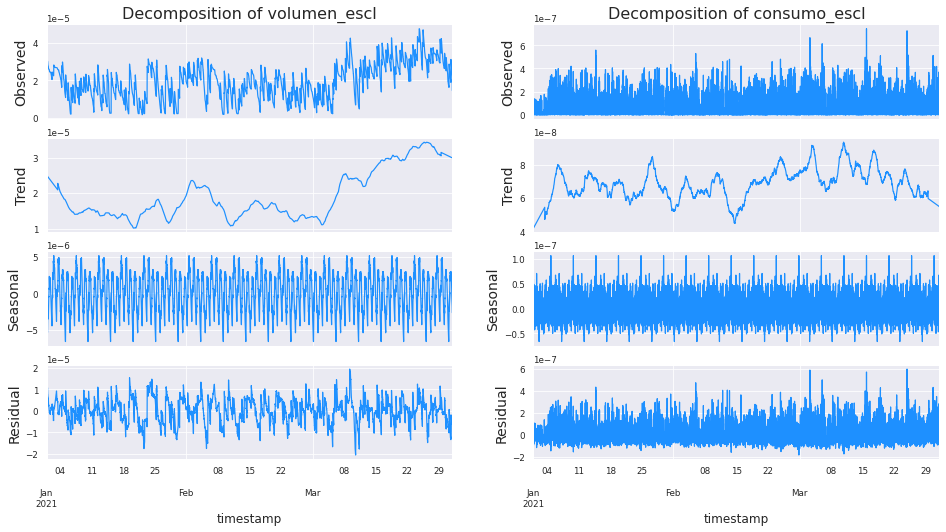

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['volumen_escl', 'consumo_escl']):
    
    res = seasonal_decompose(co_248_d500[column], freq=60*24, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)


Vamos a analizar el comportamiento respecto a:
- Momento de la semana.
- Horario laboral habitual.
- Turnos mañana, tarde y noche.

Observamos ejemplos sobre dos grandes grupos de producto (Diesel y Nafta).

In [ ]:
co_900_nafta = curated_pkl[(curated_pkl["id_equipo"] == "900") & (curated_pkl["nombre_producto"] == "Nafta Super")] 
co_900_diesel = curated_pkl[(curated_pkl["id_equipo"] == "900") & (curated_pkl["nombre_producto"] == "Formula Diesel")] 
co_477_nafta = curated_pkl[(curated_pkl["id_equipo"] == "477") & (curated_pkl["nombre_producto"] == "VP Nafta")] 
co_248_diesel = curated_pkl[(curated_pkl["id_equipo"] == "248") & (curated_pkl["nombre_producto"] == "D500")] 

In [ ]:
sd_900_nafta = seasonal_decompose(
    co_900_nafta['volumen_escl'].astype(float), 
    freq=60*24
)
sd_900_diesel = seasonal_decompose(
    co_900_diesel['volumen_escl'].astype(float), 
    freq=60*24
)
sd_477_nafta = seasonal_decompose(
    co_477_nafta['volumen_escl'].astype(float), 
    freq=60*24
)
sd_248_diesel = seasonal_decompose(
    co_248_diesel['volumen_escl'].astype(float), 
    freq=60*24
)

In [ ]:
# Rangos de tiempo dummy para marcar turnos, fines de semana en los gráficos
daily_range = pd.date_range(start='2021-02-22', end='2021-04-01', freq='D')
hourly_range = pd.date_range(start='2021-02-22', end='2021-04-01', freq='H')

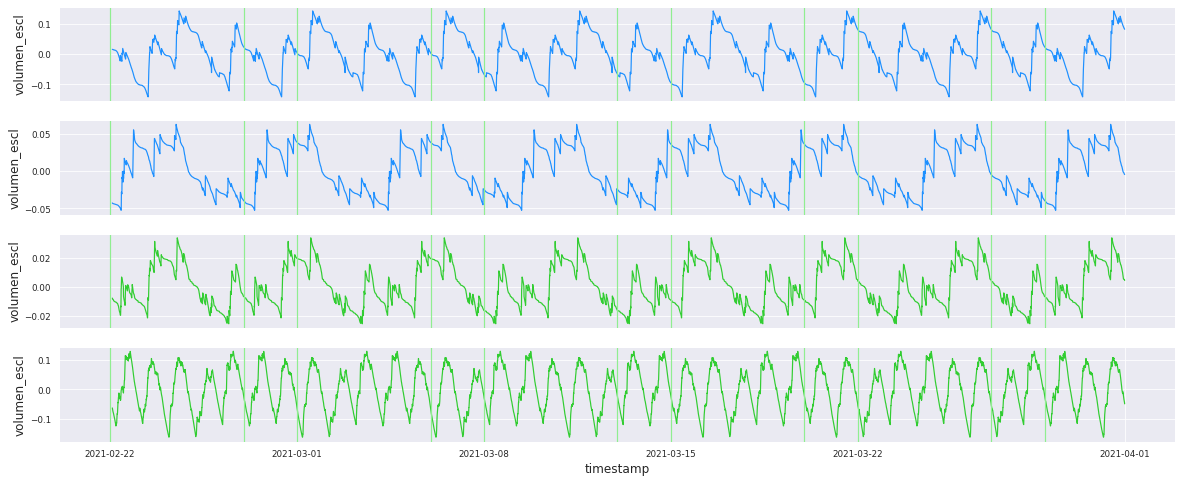

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20, 8))
# Semana vs fines de semana
g = seaborn.lineplot(
    data=sd_900_nafta.seasonal[15000:], 
    color='dodgerblue',
    ax=axes[0]
)
[g.axes.axvline(d, color='lightgreen') for d in daily_range if d.weekday() in [0,5]]
g = seaborn.lineplot(
    data=sd_477_nafta.seasonal[15000:], 
    color='dodgerblue',
    ax=axes[1]
)
[g.axes.axvline(d, color='lightgreen') for d in daily_range if d.weekday() in [0,5]]

g = seaborn.lineplot(
    data=sd_900_diesel.seasonal[15000:], 
    color='limegreen',
    ax=axes[2]
)
[g.axes.axvline(d, color='lightgreen') for d in daily_range if d.weekday() in [0,5]]
g = seaborn.lineplot(
    data=sd_248_diesel.seasonal[15000:], 
    color='limegreen',
    ax=axes[3]
)
[g.axes.axvline(d, color='lightgreen') for d in daily_range if d.weekday() in [0,5]]
plt.show()

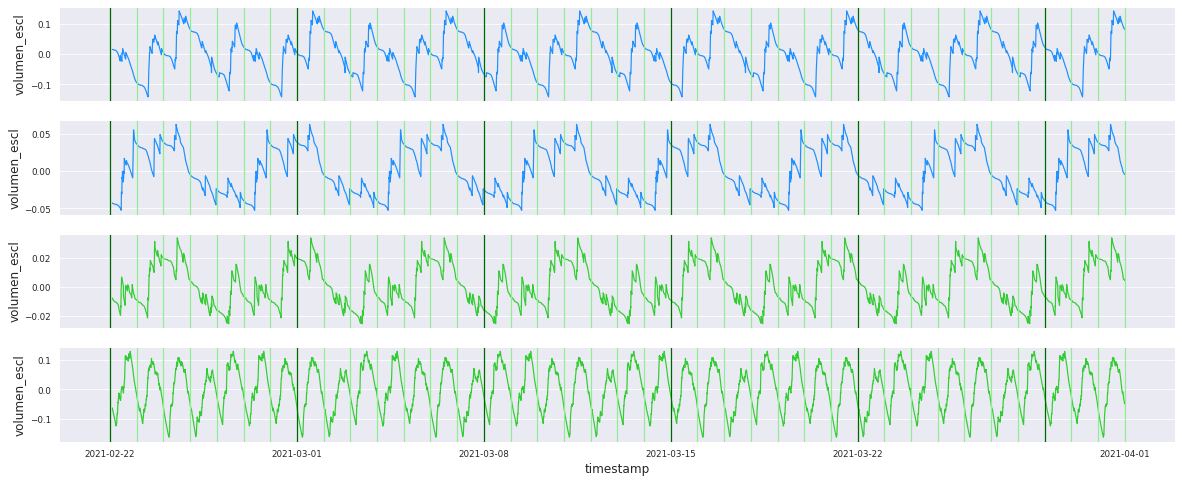

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20, 8))
# Diario
g = seaborn.lineplot(
    data=sd_900_nafta.seasonal[15000:], 
    color='dodgerblue',
    ax=axes[0]
)
[g.axes.axvline(d, color='lightgreen') for d in daily_range]
[g.axes.axvline(d, color='darkgreen') for d in daily_range if d.weekday() == 0]
g = seaborn.lineplot(
    data=sd_477_nafta.seasonal[15000:], 
    color='dodgerblue',
    ax=axes[1]
)
[g.axes.axvline(d, color='lightgreen') for d in daily_range]
[g.axes.axvline(d, color='darkgreen') for d in daily_range if d.weekday() == 0]

g = seaborn.lineplot(
    data=sd_900_diesel.seasonal[15000:], 
    color='limegreen',
    ax=axes[2]
)
[g.axes.axvline(d, color='lightgreen') for d in daily_range]
[g.axes.axvline(d, color='darkgreen') for d in daily_range if d.weekday() == 0]
g = seaborn.lineplot(
    data=sd_248_diesel.seasonal[15000:], 
    color='limegreen',
    ax=axes[3]
)
[g.axes.axvline(d, color='lightgreen') for d in daily_range]
[g.axes.axvline(d, color='darkgreen') for d in daily_range if d.weekday() == 0]
plt.show()

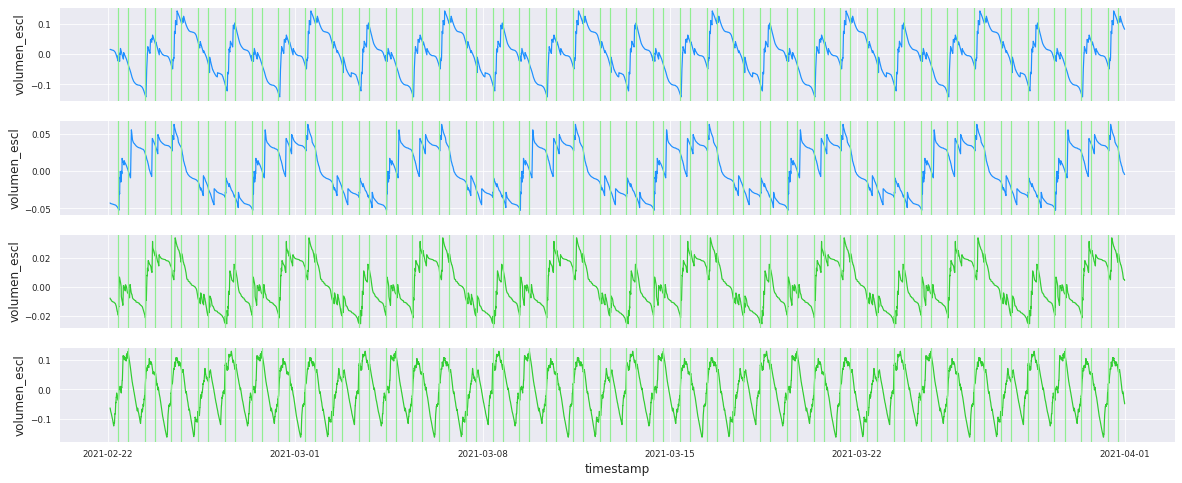

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20, 8))
# Horario laboral habitual
g = seaborn.lineplot(
    data=sd_900_nafta.seasonal[15000:], 
    color='dodgerblue',
    ax=axes[0]
)
[g.axes.axvline(h, color='lightgreen') for h in hourly_range if h.hour in [9, 18]]
g = seaborn.lineplot(
    data=sd_477_nafta.seasonal[15000:], 
    color='dodgerblue',
    ax=axes[1]
)
[g.axes.axvline(h, color='lightgreen') for h in hourly_range if h.hour in [9, 18]]

g = seaborn.lineplot(
    data=sd_900_diesel.seasonal[15000:], 
    color='limegreen',
    ax=axes[2]
)
[g.axes.axvline(h, color='lightgreen') for h in hourly_range if h.hour in [9, 18]]
g = seaborn.lineplot(
    data=sd_248_diesel.seasonal[15000:], 
    color='limegreen',
    ax=axes[3]
)
[g.axes.axvline(h, color='lightgreen') for h in hourly_range if h.hour in [9, 18]]
plt.show()

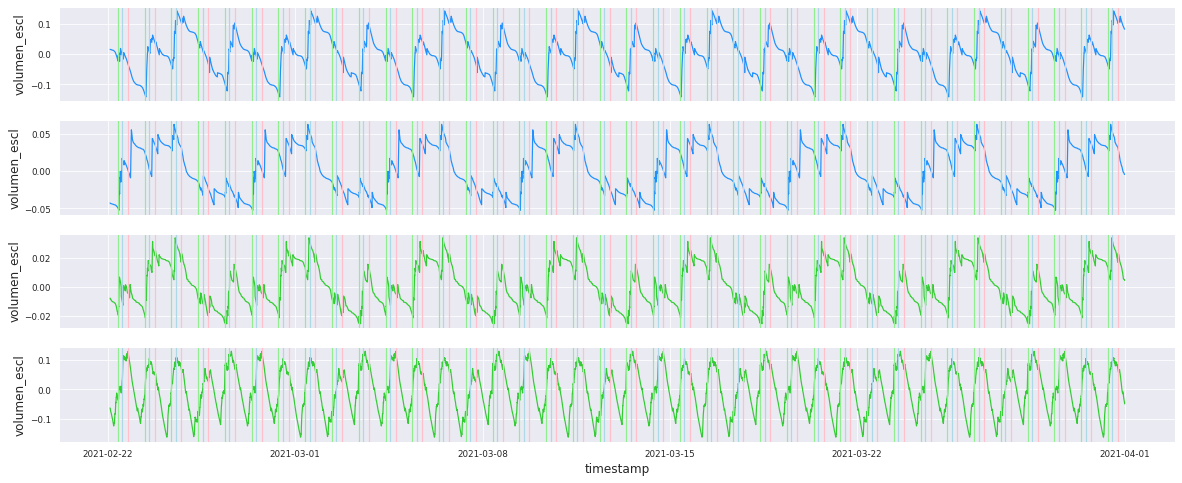

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20, 8))
# Turnos
g = seaborn.lineplot(
    data=sd_900_nafta.seasonal[15000:], 
    color='dodgerblue',
    ax=axes[0]
)
[g.axes.axvline(h, color='lightgreen') for h in hourly_range if h.hour == 9]
[g.axes.axvline(h, color='lightblue') for h in hourly_range if h.hour == 13]
[g.axes.axvline(h, color='pink') for h in hourly_range if h.hour == 18]
g = seaborn.lineplot(
    data=sd_477_nafta.seasonal[15000:], 
    color='dodgerblue',
    ax=axes[1]
)
[g.axes.axvline(h, color='lightgreen') for h in hourly_range if h.hour == 9]
[g.axes.axvline(h, color='lightblue') for h in hourly_range if h.hour == 13]
[g.axes.axvline(h, color='pink') for h in hourly_range if h.hour == 18]

g = seaborn.lineplot(
    data=sd_900_diesel.seasonal[15000:], 
    color='limegreen',
    ax=axes[2]
)
[g.axes.axvline(h, color='lightgreen') for h in hourly_range if h.hour == 9]
[g.axes.axvline(h, color='lightblue') for h in hourly_range if h.hour == 13]
[g.axes.axvline(h, color='pink') for h in hourly_range if h.hour == 18]
g = seaborn.lineplot(
    data=sd_248_diesel.seasonal[15000:], 
    color='limegreen',
    ax=axes[3]
)
[g.axes.axvline(h, color='lightgreen') for h in hourly_range if h.hour == 9]
[g.axes.axvline(h, color='lightblue') for h in hourly_range if h.hour == 13]
[g.axes.axvline(h, color='pink') for h in hourly_range if h.hour == 18]
plt.show()

A grandes rasgos se puede observar:
- Abastecimientos en horarios laborables habituales.
- Mayores consumos en horarios nocturnos.

## Conclusiones

- En principio se llevará a cabo un modelo por centro operativo y producto. En una segunda instancia, se probará un modelo con todos los centros operativos y con hiperparámetros, es por esto que se incluyó la industria en el datadet. Se tendrá en cuenta un período de tiempo en particular para realizar la predicción, para esto será de gran utilidad la descomposición de las series temporales.